In [6]:
import plot_top as pltt
""" mostly plotting results for rocky planet evolution + topographies """
%matplotlib inline
import numpy as np
import parameters as p
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from collections.abc import Iterable
import collections
import six
from scipy import interpolate
import pandas as pd
from IPython.display import display, Math
import random as rand
import terrestrialplanet as tp
import thermal as therm
import topography as top
import rheology as rh
import inputs as ins
from mpl_tools import colorize
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
from matplotlib import rc

# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop#
goodfig_path = 'latex/report-firstyr/figs/'

plt.style.use('dark_background')

mpl.rcParams['axes.linewidth'] = 2 #set the value globally - for poster

In [2]:
def read_JFR(fname='', path='benchmarks/JFR/'):
    df = pd.read_csv(path+fname, header=0, index_col=False)
    Ra = np.array(df.Ra)
    h_peak = np.array(df.peak_topo)
    h_rms = np.array(df.RMS_topo) 
    Nu = np.array(df.Nu)
    return Ra, h_peak, h_rms, Nu
    

def powerspectrum_RMS(path=None, power_lm=None, amplitude=False, n=None): # try to calcuate RMS from digitized power spectrum
    if path is not None:
        df = pd.read_csv(path, header=None, names=['degree', 'value'], index_col=False) 
        ls = np.array(df['degree'])
        S = np.array(df['value'])
    elif power_lm is not None:
        ls = np.arange(1, len(power_lm)-1)
        S = power_lm

    if n is None:
        n = len(ls)

    RMS_l = []
    for ii, l in enumerate(ls[0:n]):
        Slm = S[ii]
        if amplitude:
            Slm = Slm**2
        RMS_l.append(np.sqrt(Slm/(2*l + 1)))
    return sum(RMS_l)

In [3]:
def RaF_to_Ra(RaF=None, k=None, F=None, d=None, Nu=None):
    if Nu is None:
        return (RaF/0.12)**(3/4) # turcotte and schubert
    else:
        return RaF/Nu
    
def dT_Ra(eta_0=None, kappa=None, Ra=None, rho=None, g=None, alpha=None, d=None, RaF=None, Nu=None, F=None, 
          k=None, nu_0=None):
    if Ra is None:
        Ra = RaF_to_Ra(RaF=RaF, Nu=Nu)
    if eta_0 is None:
        if nu_0 is not None:
            eta_0 = nu_0*rho
        else:
            eta_0 = rho*g*alpha*d**4*F/(k*kappa)
    return eta_0*kappa*Ra/(rho*g*alpha*d**3)

In [4]:
def hprime_MP(h=None, alpha=None, d=None, F=None, C_p=None, kappa=None, Ra_b=None, eta_0=None, 
              rho=None, g=None, k=None, dT=None, nu_0=None):
    
    if eta_0 is None:
        if nu_0 is not None:
            eta_0 = nu_0*rho
        elif dT is None:
            eta_0 = rho*g*alpha*d**4*F/(k*kappa)
        elif F is None:
            eta_0 = rho*g*alpha*d**3*dT/(kappa*Ra_b)
    return h/(eta_0*kappa/(d**2*rho*g))

def hprime(h=None, alpha=None, k=None, d=None, kappa=None, rho=None, c_p=None, F=None, dT=None,
           eta_0=None, Ra=None, g=None, RaF=None, Nu=None, nu_0=None):
    if dT is None:
        dT = dT_Ra(eta_0=eta_0, kappa=kappa, Ra=Ra, rho=rho, g=g, alpha=alpha, d=d, RaF=RaF, Nu=Nu, F=F,
                   nu_0=nu_0, k=k)
    return h/(alpha*dT*d)

In [37]:
def hprime_v_Ra(plots_save=False, figpath='', fname='fig', legsize=14, leg_ncol=1, c_main='k',
                legtitle=r'\textbf{\textit{Model}}', dimensional=False, **kwargs):

    pl_list = pltt.build_solarsystem(dicts=True, run_args={'D_l0':10e3, 'T_m0':1700},
                                ident_list=['Venusbaseline', 'Mars1'])

    print('for white bg you might wanna change alphas back to 0.8')
    # TODO: colour code by viscosity or geometry

    pl = pl_list['Venusbaseline'] # planets
    a_rh = pl.a_rh
    alpha = pl.alpha_m
    T_m = pl.T_m[-1]
    Ea = pl.Ea
    dT_rh = p.R_b*T_m**2/Ea
    dT_m =  pl.deltaT_m
    eta_m = pl.eta_m[-1]
    kappa_m = pl.kappa_m
    d_m = pl.d_m
    Ra_crit = pl.Ra_crit_u
    
    if dimensional:
        hscale = alpha*dT_m[-1]*d_m[-1]
        print('alpha=', alpha, 'dT=', dT_m[-1], 'd=', d_m[-1])
    else:
        hscale = 1
    
    
    # load JFR runs
    Ra_T, h_peak_T, h_rms_T, _ = read_JFR('fixed_T_stats.csv')
    Ra_f, h_peak_f, h_rms_f, Nu_f = read_JFR('fixed_flux_stats.csv')
    Ra_2T, h_peak_2T, h_rms_2T, _ = read_JFR('2Dcart_fixed_T_stats.csv')
    Ra_2f, h_peak_2f, h_rms_2f, Nu_2f = read_JFR('2Dcart_fixed_flux_stats.csv')
    
    

    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5,7))
    ax0.set_yscale('log')
    ax1.set_yscale('log')

    
    # dummy
    fig, ax0 = pltt.plot_vs_x(lplanets=pl,     xname = {'Ra_i':('', 1)},
                         ynames={'dyn_top_rms':('$\Delta h^\prime_{\mathrm{peak}}$', 0)}, 
                         set_ylim=False,c='w',fig=fig, axes=ax0, **kwargs)
    fig, ax1 = pltt.plot_vs_x(lplanets=pl,     xname = {'Ra_i':('Ra', 1)},
                         ynames={'dyn_top_rms':('$\Delta h^\prime_{\mathrm{RMS}}$', 0)}, 
                         set_ylim=False,c='w',fig=fig, axes=ax1, **kwargs)
#         #  (thermal hitory)
#     fig, ax1 = pltt.plot_vs_x(lplanets=pl, xname = {'Ra_i':('Ra', 1)}, 
#                          ynames={'dyn_top_rms':('$\Delta h^\prime_{RMS}$', eval('(pl.alpha_m*pl.deltaT_m*pl.d_m)**-1'))},
#                          set_ylim=False,
#                         c='k', ls='-', lw=3, 
#                         label_l=r'Parsons \& Daly (1983) with thermal history',
#                         fig=fig, axes=ax1, **kwargs)
    
    
    
    # plot Ra scaling across the board from PD and stress , i guess fixing some parameters
    Ra_main = np.logspace(4, np.log10(np.max(pl.Ra_i)))
#     h_PD83_Ra = 5.4*alpha*d_m[-1]*(a_rh*dT_rh*dT_m[-1]/Ra_crit**(1/3))**0.5 * Ra_main**(-1/3)
#     hprime_PD83_Ra = hprime(h=h_PD83_Ra, alpha=alpha, d=d_m[-1], dT=dT_m[-1])
    hprime_PD83_Ra = 5.4 * Ra_main**(-1/3)
    
#     ax0.plot(Ra_main, hprime_PD83_Ra, lw=1, ls='--', c='k', 
#             label=r'Parsons \& Daly (1983), RMS scaling') 
    

    
    # plot JFR convection runs
    ax0.plot(Ra_T, hscale*h_peak_T, ls='-', lw=1, c='#698ff3', label='2D cylindrical, fixed $\Delta T_m$') # xkcd:blurple
    ax0.plot(Ra_f/Nu_f, hscale*h_peak_f*Nu_f, ls='-', lw=1, c='#cacaca', label='2D cylindrical, fixed flux')# xkcd:grey
    ax0.plot(Ra_2T, hscale*h_peak_2T, ls='-.', lw=1, c='#698ff3', label='2D cartesian, fixed $\Delta T_m$') # xkcd: blurple
    ax0.plot(Ra_2f/Nu_f, hscale*h_peak_2f*Nu_f, ls='-.', lw=1, c='#cacaca', label='2D cartesian, fixed flux') #xkcd:grey
    
    
    # KH92 for Ra 10^4-10^5 constant eta
    Ra = np.logspace(4, 8) # plotting to logRa=8 although that's not actually valid for their fit
    h_KH92 = (66*Ra**-0.121)*0.7e3 
    hprime_KH92 = h_KH92/(3e-5*1000*2800e3)
    ax0.plot(Ra, hscale*hprime_KH92, lw=2, ls='--', c='xkcd:raspberry', 
            label=r'Kiefer \& Hager (1992)') # scaled from dimensional
#     Ra2 = np.logspace(5, 8)
#     h_KH92 = (66*Ra2**-0.121)*0.7e3
#     hprime_KH92 = hprime(h=h_KH92, alpha=3e-5, d=2800e3, dT=1000) #h_KH92/(3e-5*1000*2800e3)
#     ax0.plot(Ra2,  hprime_KH92,  lw=1, ls='--', c='xkcd:raspberry', alpha=1 ) 

    
    
    
    # Moresi rho*g*alpha*d**4*F/(k*kappa)
    
#     data_Moresi_hprime = hprime(h=np.array([5.8e3, 3.8e3, 5.1e3]), alpha=3.28e-5, d=750e3, dT=1092+273)

  
#     data_Moresi_Ra = RaF_to_Ra(RaF=np.array([2.4e6,1.3e6,1e6]), k=3.168, F=74e-3, d=750e3) 


    
    
    # Nimmo
#     data_Nimmo_RaF = np.array([3.95e6, 3.95e6,3.95e6,
#                      7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,
#                      1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7])
#     data_Nimmo_Ra = RaF_to_Ra(RaF=data_Nimmo_RaF)
#     data_Nimmo_h = np.array([2.847e3, 
#                     1.914e3,
#                     1.729e3, 
                    
#                     2.585e3, 
#                     2.416e3, 
#                     1.629e3, 
#                     1.955e3, 
#                     2.604e3, 
#                     2.173e3, 
#                     1.467e3, 
                    
#                     2.217e3, 
#                     2.328e3, 
#                     2.772e3, 
#                     2.023e3, 
#                     2.225e3, 
#                     2.529e3, 
#                     1.278e3, 
#                     1.703e3, 
#                     1.789e3, 
#                     1.157e3])
#     data_Nimmo_d = np.array([840e3,760e3,695e3,910e3,860e3,775e3,775e3,775e3,775e3,705e3,950e3,950e3,950e3,890e3,890e3,890e3,775e3,775e3,775e3,705e3])
#     data_Nimmo_T = 273+np.array([1210,1196,1341,1105,1232,1219,1373,1424,1475,1367,1129,1163,1298,1255,1336,1457,1213,1467,1518,1364])
#     data_Nimmo_F = np.array([20, 15, 15, 20, 20, 15,18, 19, 20, 15, 20, 21, 25, 20, 22, 25, 15, 20, 21, 15])*1e-3
#     data_Nimmo_nu = np.array([0.29e18, 0.15e18, 0.10e18, 0.2e18,0.16e18,0.79e17,0.94e17,0.1e18,0.1e18,0.54e17,
#                              0.12e18, 0.12e18,0.15e18,0.91e17,0.1e18,0.11e18,0.39e17,0.52e17,0.55e17,0.27e17])
#     data_Nimmo_hprime = hprime(h=data_Nimmo_h, dT=None, d=data_Nimmo_d, alpha=3.28e-5, kappa=8e-7, 
#                                rho=3300, F=data_Nimmo_F, eta_0=None, g=8.87, RaF=data_Nimmo_RaF, nu_0=data_Nimmo_nu)
    
#     ax0.scatter(data_Nimmo_Ra, data_Nimmo_hprime, marker='d', s=70, alpha=0.7,
#                c='xkcd:pale orange', 
#                label=r'Nimmo \& McKenzie (1996)$^\dagger$')
    
    
    #Lees
    Ra_l = [1e6, 3e5, 1e5]
    h_rms_prime_Lees = np.array([0.08411800809, 0.105032009653, 0.125746699674])
    ax0.scatter(Ra_l, hscale*h_rms_prime_Lees, c='xkcd:pale orange', marker='d', s=90, zorder=200, alpha=1,
                label=r'Lees+ (2020)') 
    
    
    # pole values from KK98 - TODO
    
    ###################
    
    #       RMS       #
    
    ###################
    
    # plot JFR convection runs
    ax1.plot(Ra_T, hscale*h_rms_T, ls='-', lw=1, c='#698ff3')
    ax1.plot(Ra_f/Nu_f, hscale*h_rms_f*Nu_f, ls='-', lw=1, c='#cacaca')
    ax1.plot(Ra_2T, hscale*h_rms_2T, ls='-.', lw=1, c='#698ff3')
    ax1.plot(Ra_2f/Nu_f, hscale*h_rms_2f*Nu_f, ls='-.', lw=1, c='#cacaca')
    
    
    # Simple PD scaling
    ax1.plot(Ra_main, hscale*hprime_PD83_Ra, lw=2, ls='--', c=c_main,
            label=r'$\Delta h \propto $ Ra$^{-1/3}$') #r'Parsons \& Daly (1983) scaling')     


    
    
    # plot Lees fit free-slip (free-free) - our PD is scaled to match their RMS, exponent lower than -1/3 because dT is outside scaling
    #h_rms_prime_Lees = 1.191*Ra**-0.289
    Ra_l = [1e6, 3e5, 1e5]
    h_rms_prime_Lees = np.array([235/442, 476/651, 943/912])/(4e-5*600e3)
    ax1.scatter(Ra_l, hscale*h_rms_prime_Lees, c='xkcd:pale orange', marker='d', s=90, zorder=200, alpha=1,
                #label=r'Lees+ (2020)'
               ) 

    
    # plot scatter points from KK98 model1
    data_KK98_h = np.array([0.006, 0.01])*pl.R_p/2800e3 # convert from their nondimensionalization to match KH
    data_KK98_Ra = [1e6, 1e6]
    ax1.plot(data_KK98_Ra, hscale*data_KK98_h, marker='.', ls='-', lw=1, alpha=1,
               c='xkcd:carnation', ms=10,
               label=r'Kiefer \& Kellogg (1998)')

    
    # plot RMS from spectra
    
    # Huang cases 1-13, 15
    huang_h = np.array([200.15279436132423 , 688.2014927583677 , 673.7880493468331 , 402.07565967751117 , 695.2136989391211 , 672.4561163950626 , 214.12066607342535 , 488.4601789919337 , 878.5607285545191 , 292.43829959982384 , 311.3352436867767 , 339.3664129742059 , 640.1361418805931 , 430.1894190342128 ])
    huang_Ra = np.array([7.3e6,7.3e6,7.3e6,7.3e6,3.7e6,1.5e7,7.3e6,7.3e6,7.3e6,1.8e7,2.7e7,3.6e7,1.8e7,1.8e7])
    huang_dlith = np.array([245,182,134,103,167,109,236,245,270,197,176,170,212,200])*1e3
    huang_alpha = 2e-5
    huang_dT = 2500
    huang_RpminusRc = 6050e3-3330e3
    scale = huang_alpha*huang_dT*(huang_RpminusRc-huang_dlith)
    ax1.scatter(huang_Ra, hscale*huang_h/scale, marker='v', s=70, alpha=1,
           c='xkcd:orchid', 
           label=r'Huang+ (2013)')
    
    # plot own data
    if dimensional:
        h_Venus = pl.dyn_top_rms[-1]
    else:
        h_Venus = hprime(h=pl.dyn_top_rms[-1], alpha=alpha, d=d_m[-1], dT=dT_m[-1])
    ax1.scatter(pl.Ra_i[-1], h_Venus, 
                marker='*', s=110, alpha=1, c=c_main,
               label=r'This work, Venus')
    print('this work h rms =', pl.dyn_top_rms[-1], 'm; Ra = ', pl.Ra_i[-1])
    
    
    pl = pl_list['Mars1'] # planets
    if dimensional:
        h_Mars = pl.dyn_top_rms[-1]
    else:
        h_Mars = hprime(h=pl.dyn_top_rms[-1], alpha=alpha, d=d_m[-1], dT=dT_m[-1])
    ax1.scatter(pl.Ra_i[-1], h_Mars, 
                marker='P', s=90, alpha=1, c=c_main,
               label=r'This work, Mars')
    print('this work h rms =', pl.dyn_top_rms[-1], 'm; Ra = ', pl.Ra_i[-1])
#     i = -50
#     ax1.scatter(pl.Ra_i[i], hprime(h=pl.dyn_top_rms[i], alpha=alpha, d=d_m[i], dT=dT_m[i]), 
#                 marker='*', s=90, alpha=0.9, c='k',)
    
#     # RMS scatter for Wei+ 2014   
#     data_Wei_Ra = 1.8e7
#     data_Wei_h = powerspectrum_RMS('benchmarks/wei_Venus/model_power_m2_b.csv')/(2e-5*2500*(6050e3-3330e3-245e3))
#     ax1.scatter(data_Wei_Ra, data_Wei_h, marker='s', s=70, alpha=0.9,
#            c='xkcd:orchid', 
#            label=r'8 Huang+ (2013)$^\ddagger$')
#     print(powerspectrum_RMS('benchmarks/wei_Venus/model_power_m2_b.csv'), 'Huang 8')

    
#     # RMS scatter for Yang2016  
#     data_Yang_h = powerspectrum_RMS('benchmarks/yang_Venus/h_amplitude_m.csv', amplitude=True)/(2e-5*2500*(6050e3-3330e3-200e3))
#     data_Yang_Ra = 7.3e6
#     ax1.scatter(data_Yang_Ra, data_Yang_h, marker='o', s=70, alpha=0.9,
#            c='xkcd:orchid', 
#            label=r'Yang+ (2016)$^\ddagger$')
    
    
    #~~~~
    #    LEGEND
    #~~~~

    
    legend=ax0.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), 
                      ncol=leg_ncol,
              borderaxespad=0, title=legtitle, )
    if legtitle is not None:
            plt.setp(legend.get_title(),fontsize=legsize)
            legend._legend_box.align = "left"
    legend=ax1.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), 
                     ncol=leg_ncol, borderaxespad=0, )
    fig.subplots_adjust(hspace = 0.15)
    if plots_save:
        fig.savefig(figpath+fname+'.pdf', bbox_inches='tight') 
    print('hscale',hscale)
    return fig, (ax0, ax1)


for white bg you might wanna change alphas back to 0.8
alpha= 3e-05 dT= 362.740462627592 d= 2686491.3646714916


/home/claire/Works/exo-top/plot_top.py:545: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.plot(x, y, ls=ls, c=c, lw=lw, alpha=alpha, zorder=zorder_l, label=label_l)
/home/claire/Works/exo-top/plot_top.py:545: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.plot(x, y, ls=ls, c=c, lw=lw, alpha=alpha, zorder=zorder_l, label=label_l)


this work h rms = 41.74351680287474 m; Ra =  1935822518.1946335
this work h rms = 84.18709616388429 m; Ra =  9265435.435287626
hscale 29234.973613979037


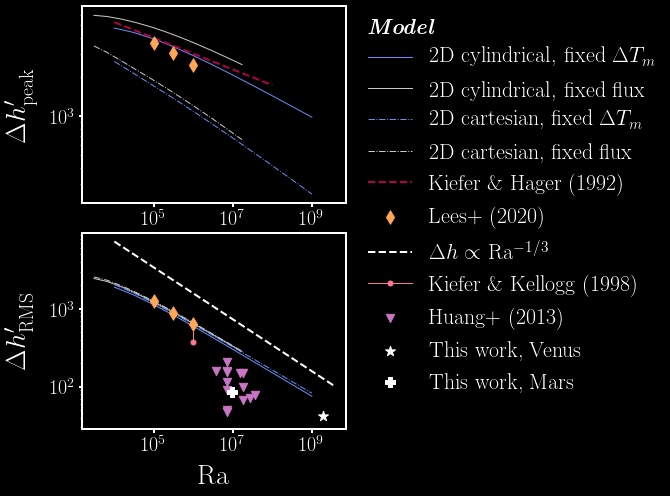

In [38]:
# poster
fname = 'Ra_hprime'
fig, axes = hprime_v_Ra(plots_save=False, figpath=fig_path, fname=fname, labelpad=10,
                 labelsize=28, legsize=22, ticksize=20, leg_ncol=1, c_main='w', dimensional=True) 


for ax in axes:
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
fig.savefig(fig_path+fname+'.png', bbox_inches='tight', rasterized=True, dpi=600) 


/home/claire/Works/exo-top/plot_top.py:543: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.plot(x, y, ls=ls, c=c, lw=lw, alpha=alpha, zorder=zorder_l, label=label_l)
/home/claire/Works/exo-top/plot_top.py:543: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.plot(x, y, ls=ls, c=c, lw=lw, alpha=alpha, zorder=zorder_l, label=label_l)


this work h rms = 84.18709616388429 m; Ra =  9265435.435287626


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


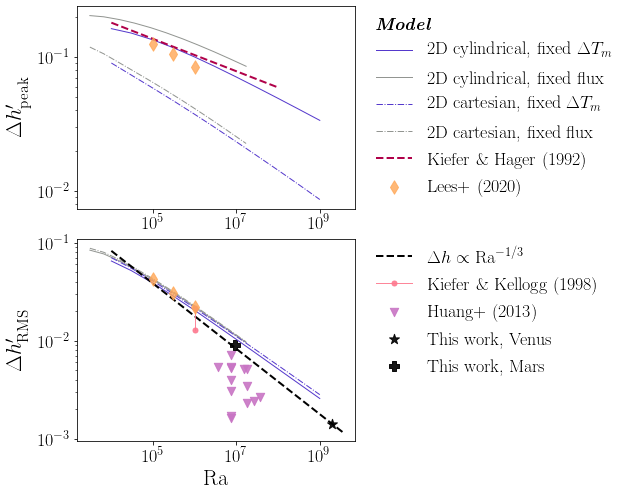

In [12]:
# plot Ra_th vs h prime both panels. convert Ra = Ra_b*k/(F*d)



goodname='Ra_hprime2'
fig, ax = hprime_v_Ra(plots_save=True, figpath=goodfig_path, fname=goodname, labelpad=5,
                 labelsize=22, legsize=18, ticksize=18, leg_ncol=1)    


pl_h_scale 66215.98308092871 hprime = scale times h
MP: $h{_km}$ = $h\prime$ x  436.78977272727263


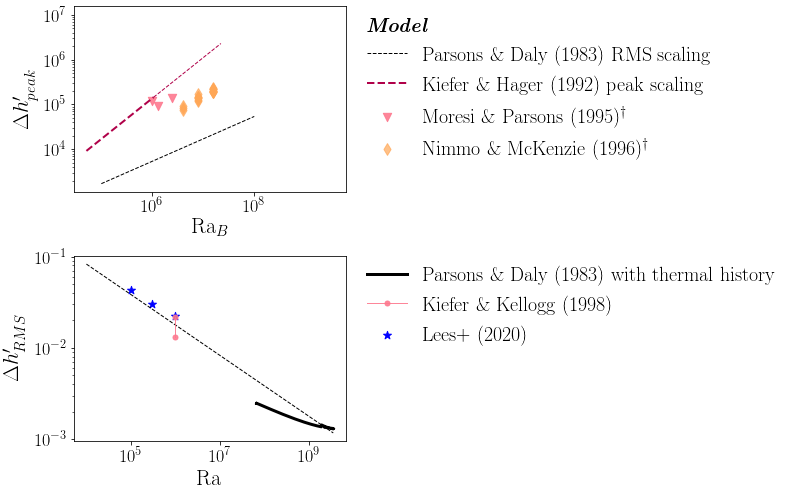

In [81]:
# Ra_b version



def hprime_v_Rab(plots_save=False, figpath='', fname='fig', legsize=14, leg_ncol=1, legtitle=r'\textbf{\textit{Model}}', **kwargs):
    pl_list = pltt.build_solarsystem(dicts=True, run_args={'D_l0':10e3, 'T_m0':1700},
                                ident_list=['Venusbaseline'])

    # TODO: colour code by viscosity or geometry


    pl = pl_list['Venusbaseline'] # planets
    a_rh = pl.a_rh
    alpha = pl.alpha_m
    T_m = pl.T_m[-1]
    Ea = pl.Ea
    dT_rh = p.R_b*T_m**2/Ea
    dT_m =  pl.deltaT_m
    
    eta_m = pl.eta_m[-1]
    kappa_m = pl.kappa_m
    d_m = pl.d_m
    Ra_crit = pl.Ra_crit_u
    

    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5,7))
    
    ax0.set_yscale('log')
    ax1.set_yscale('log')
    
    # plot Ra scaling across the board from PD and stress , i guess fixing some parameters
    

    Ra = np.logspace(5, 8)
    ax0.plot(Ra, 5.4*Ra**0.5, lw=1, ls='--', c='k', 
            label=r'Parsons \& Daly (1983) RMS scaling') 
    
#     ax0.plot(Ra, h_PD83_Ra/(alpha*dT_m[-1]*d_m[-1]), lw=1, ls='--', c='k', 
            #label=r'Parsons \& Daly (1983) scaling') 
    Ra = np.logspace(4, np.log10(np.max(pl.Ra_i)))
    h_PD83_Ra = 5.4*alpha*d_m[-1]*(a_rh*dT_rh*dT_m[-1]/Ra_crit**(1/3))**0.5 * Ra**(-1/3)
    
    ax1.plot(Ra, h_PD83_Ra/(alpha*dT_m[-1]*d_m[-1]), lw=1, ls='--', c='k') 
    

    fig, ax1 = pltt.plot_vs_x(lplanets=pl, xname = {'Ra_i':('Ra', 1)}, 
                         ynames={'dyn_top_rms':('$\Delta h^\prime_{RMS}$', eval('(pl.alpha_m*pl.deltaT_m*pl.d_m)**-1'))},
                         set_ylim=False,
                        c='k', ls='-', lw=3, 
                        label_l=r'Parsons \& Daly (1983) with thermal history',
                        fig=fig, axes=ax1, **kwargs)
    
    pl_h_scale = hprime_MP(h=1, alpha=pl.alpha_m, d=pl.d_m[-1], dT=pl.deltaT_m[-1], kappa=pl.kappa_m, 
                           eta_0=pl.eta_m[-1], rho=pl.rho_m, g=pl.g_sfc, k=pl.k_m)
    print('pl_h_scale', pl_h_scale, 'hprime = scale times h')
    
    # dummy
    fig, ax0 = pltt.plot_vs_x(lplanets=pl,     xname = {'Ra_i':('Ra$_B$', 1)},
                         ynames={'dyn_top_rms':('$\Delta h^\prime_{peak}$', 
                                               pl_h_scale)}, 
                         set_ylim=False,c='w',fig=fig, axes=ax0, **kwargs)
    



    
    # plot Lees fit free-slip (free-free) - our PD is scaled to match their RMS, exponent lower than -1/3 because dT is outside scaling
    #h_rms_prime_Lees = 1.191*Ra**-0.289
    Ra_l = [1e6, 3e5, 1e5]
    h_rms_prime_Lees = np.array([235/442, 476/651, 943/912])/(4e-5*600e3)
    ax1.scatter(Ra_l, h_rms_prime_Lees, marker='*', c='b', s=70,
                label=r'Lees+ (2020)') 

 
#     # load data points from model run
#     df = pd.read_csv('data_for_claire/stats.csv', header=0, index_col=False)
#     h_peak_JFR = np.array(df.peak_topo)
#     h_rms_JFR = np.array(df.RMS_topo)
#     ax0.scatter(np.array(df.Ra), h_peak_JFR, marker='x', c='xkcd:blurple', 
#                label='cylindrical peak')
#     ax1.scatter(np.array(df.Ra), h_rms_JFR, marker='x', c='xkcd:lavender', 
#                label='cylindrical RMS')
#     print('h_RMS/h_peak, cylindrical = ',h_rms_JFR/ h_peak_JFR)
    
    
    # KH92 for Ra 10^4-10^5 constant eta
    Ra = np.logspace(4, 5)
    h_KH92 = (66*Ra**-0.121)*0.7e3 
    Nu = 0.27*Ra**0.319
    Ra_B = Ra*Nu
    hprime_KH92 = hprime_MP(h=h_KH92, alpha=3e-5, d=2800e3, dT=1000, kappa=1e-6, Ra_b=Ra_B, rho=3300, g=8.87, k=3)
    ax0.plot(Ra*Nu, hprime_KH92, lw=2, ls='--', c='xkcd:raspberry', 
            label=r'Kiefer \& Hager (1992) peak scaling') # scaled from dimensional
    
    Ra2 = np.logspace(5, 6)
    Nu2 = 0.27*Ra2**0.319
    h_KH92 = (66*Ra2**-0.121)*0.7e3
    hprime_KH92 = hprime_MP(h=h_KH92, alpha=3e-5, d=2800e3, dT=1000, kappa=1e-6, Ra_b=Ra2*Nu2, rho=3300, g=8.87, k=3)
    
    ax0.plot(Ra2*Nu2,  hprime_KH92,
             lw=1, ls='--', c='xkcd:raspberry', alpha=1 ) 
    
    
    
    
    # RMS scatter for Moresi & Parsons  
    data_Moresi_hprime = [hprime_MP(h=5.8e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168),
                     hprime_MP(h=3.8e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168),
                     hprime_MP(h=5.1e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168)]
      
    print('MP: $h{_km}$ = $h\prime$ x ', 5.8/hprime_MP(h=5.8e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168))    
    data_Moresi_hprime = np.array([5.8, 3.8, 5.1])/4.20e-5
    data_Moresi_Ra = [2.4e6,1.3e6,1e6]
    ax0.scatter(data_Moresi_Ra, data_Moresi_hprime, marker='v', s=70, alpha=0.9,
               c='xkcd:carnation', 
               label=r'Moresi \& Parsons (1995)$^\dagger$')
    
    
    
    
    # plot scatter points from Nimmo
    data_Nimmo_h = np.array([2.847e3, 
                    1.914e3,
                    1.729e3, 
                    
                    2.585e3, 
                    2.416e3, 
                    1.629e3, 
                    1.955e3, 
                    2.604e3, 
                    2.173e3, 
                    1.467e3, 
                    
                    2.217e3, 
                    2.328e3, 
                    2.772e3, 
                    2.023e3, 
                    2.225e3, 
                    2.529e3, 
                    1.278e3, 
                    1.703e3, 
                    1.789e3, 
                    1.157e3])    
    data_Nimmo_hprime = [
        hprime_MP(h=2.847e3, nu_0=0.29e18, alpha=3.28e-5, d=840e3, F=20e-3, kappa=8e-7, Ra_b=3.95e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.914e3, nu_0=0.15e18, alpha=3.28e-5, d=760e3, F=15e-3, kappa=8e-7, Ra_b=3.95e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.729e3, nu_0=0.10e18, alpha=3.28e-5, d=695e3, F=15e-3, kappa=8e-7, Ra_b=3.95e6, rho=3300, g=8.87, k=3.17),
        
        hprime_MP(h=2.585e3,  nu_0=0.20e18,alpha=3.28e-5, d=910e3, F=20e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.416e3,  nu_0=0.16e18,alpha=3.28e-5, d=860e3, F=20e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.629e3,  nu_0=0.79e17,alpha=3.28e-5, d=775e3, F=15e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.955e3,  nu_0=0.94e17,alpha=3.28e-5, d=775e3, F=18e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.604e3,  nu_0=0.10e18,alpha=3.28e-5, d=775e3, F=19e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.173e3,  nu_0=0.10e18,alpha=3.28e-5, d=775e3, F=20e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.467e3,  nu_0=0.54e17,alpha=3.28e-5, d=705e3, F=15e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        
        hprime_MP(h=2.217e3, nu_0=0.12e18, alpha=3.28e-5, d=950e3, F=20e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.328e3, nu_0=0.12e18, alpha=3.28e-5, d=950e3, F=21e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.772e3, nu_0=0.15e18, alpha=3.28e-5, d=950e3, F=25e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.023e3, nu_0=0.91e17, alpha=3.28e-5, d=890e3, F=20e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.225e3, nu_0=0.10e18, alpha=3.28e-5, d=890e3, F=22e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.529e3, nu_0=0.11e18, alpha=3.28e-5, d=890e3, F=25e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.278e3, nu_0=0.39e17, alpha=3.28e-5, d=775e3, F=15e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.703e3, nu_0=0.52e17, alpha=3.28e-5, d=775e3, F=20e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.789e3, nu_0=0.55e17, alpha=3.28e-5, d=775e3, F=21e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.157e3, nu_0=0.27e17, alpha=3.28e-5, d=705e3, F=15e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
    ]
    
    data_Nimmo_Ra = [3.95e6, 3.95e6,3.95e6,
                     7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,
                     1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7]
    
    
    ax0.scatter(data_Nimmo_Ra, data_Nimmo_hprime, marker='d', s=70, alpha=0.7,
               c='xkcd:pale orange', 
               label=r'Nimmo \& McKenzie (1996)$^\dagger$')
    
    # plot scatter points from KK98 model1
    data_KK98_h = np.array([0.006, 0.01])*pl.R_p/2800e3 # convert from their nondimensionalization to match KH
    data_KK98_Ra = [1e6, 1e6]
    ax1.plot(data_KK98_Ra, data_KK98_h, marker='.', ls='-', lw=1, alpha=0.9,
               c='xkcd:carnation', ms=10,
               label=r'Kiefer \& Kellogg (1998)')

    


    
    legend=ax0.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), 
                      ncol=leg_ncol,
              borderaxespad=0, title=legtitle, )
    if legtitle is not None:
            plt.setp(legend.get_title(),fontsize=legsize)
            legend._legend_box.align = "left"
    legend=ax1.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), 
                      ncol=leg_ncol, borderaxespad=0, )

    if plots_save:
        fig.savefig(figpath+fname+'.pdf', bbox_inches='tight') 
    return fig, (ax0, ax1)

goodname='Ra_hprime_1'
fig, ax = hprime_v_Rab(plots_save=True, figpath=goodfig_path, fname=goodname, labelpad=5,
                 labelsize=22, legsize=20, ticksize=18, leg_ncol=1)    


our model dT_m= 362.740462627592 K; d_m 2686.4913646714917 km; alpha = 3e-05
h_RMS/h_peak =  [0.3995699  0.344259   0.28811032 0.24461471 0.20525125]


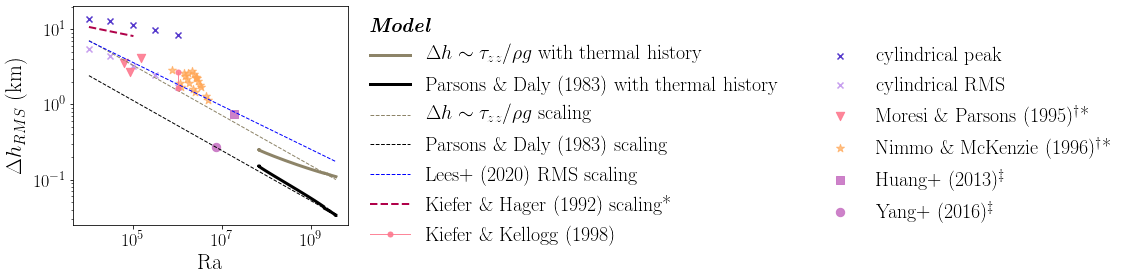

In [9]:
# make a plot of h vs. Ra - single planet evolution
# add literature model data to plot

def h_v_Ra(plots_save=False, figpath='', fname='fig', legsize=14, leg_ncol=1, legtitle=r'\textbf{\textit{Model}}', **kwargs):
    pl_list = pltt.build_solarsystem(dicts=True, run_args={'D_l0':10e3, 'T_m0':1700},
                                ident_list=['Venusbaseline'])

    # TODO: colour code by viscosity or geometry
    
    data_Moresi_h = np.array([5.8, 3.8, 5.1])*0.707
    data_Moresi_Ra = [pltt.Ra_from_RaF_2(F=74e-3, l=750e3, kappa=8e-7, rho=3300, c_p=1200, dT=1100, Ra_F=2.4e6),
                     pltt.Ra_from_RaF_2(F=74e-3, l=750e3, kappa=8e-7, rho=3300, c_p=1200, dT=1100,  Ra_F=1.3e6),
                     pltt.Ra_from_RaF_2(F=74e-3, l=750e3, kappa=8e-7, rho=3300, c_p=1200, dT=1100, Ra_F=1e6)]
    
    data_Nimmo_h = [2.847, 1.914, 1.729, 2.585, 2.416, 1.629, 1.955, 2.604, 2.173, 1.467, 2.217, 2.328, 2.772, 2.023, 2.225, 2.529, 1.278, 1.703, 1.789, 1.157] 
    data_Nimmo_Ra = [pltt.Ra_from_RaB(F=20e-3, l=840e3, k=3.17, Ra_B=3.95e6), # 
                     pltt.Ra_from_RaB(F=15e-3, l=760e3, k=3.17, Ra_B=3.95e6),
                     pltt.Ra_from_RaB(F=15e-3, l=695e3, k=3.17, Ra_B=3.95e6),
                     
                     pltt.Ra_from_RaB(F=20e-3, l=910e3, k=3.17, Ra_B=7.89e6),
                     pltt.Ra_from_RaB(F=20e-3, l=860e3, k=3.17, Ra_B=7.89e6),
                     pltt.Ra_from_RaB(F=15e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     pltt.Ra_from_RaB(F=18e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     pltt.Ra_from_RaB(F=19e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     pltt.Ra_from_RaB(F=20e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     pltt.Ra_from_RaB(F=15e-3, l=705e3, k=3.17, Ra_B=7.89e6),
              
                     pltt.Ra_from_RaB(F=20e-3, l=950e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=21e-3, l=950e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=25e-3, l=950e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=20e-3, l=890e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=22e-3, l=890e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=25e-3, l=890e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=15e-3, l=775e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=20e-3, l=775e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=21e-3, l=775e3, k=3.17, Ra_B=1.58e7),
                     pltt.Ra_from_RaB(F=15e-3, l=705e3, k=3.17, Ra_B=1.58e7),
              ]
    
    data_KH91_h = [7.5, 6.3, 5.1]
    data_KH91_Ra = [1e5, 3e5, 1e6]
    
    data_Yang_h = pltt.powerspectrum_RMS('benchmarks/yang_Venus/h_amplitude_m.csv', amplitude=True)*1e-3
    data_Yang_Ra = 7.3e6


    dT_m = 1500
    data_KK98_h = np.array([0.006, 0.01])*dT_m*6050*pl_list['Venusbaseline'].alpha_m # scaled from h' to km
  
    data_KK98_Ra = [1e6, 1e6]
    
    data_RMS = [2.733] # Golle RMS
    data_Ra = [pltt.Ra_from_RaB(F=15e-3, l=2665e3, k=3.17, Ra_B=3e8, dT=2969) ]# Golle RMS, assume F=15e-3
    data_label = [ r'Golle+ (2012)$^\dagger$']
    
    data_Wei_Ra = 1.8e7
    data_Wei_h = pltt.powerspectrum_RMS('benchmarks/wei_Venus/model_power_m2_b.csv')*1e-3
    
    czechfaction_RMS = [
        pltt.powerspectrum_RMS('benchmarks/benesova_Venus/3A2x1021_powerspectrum_m2.csv'),
#         powerspectrum_RMS('benchmarks/benesova_Venus/3A4x1022_powerspectrum_m2.csv'),
        pltt.powerspectrum_RMS('benchmarks/benesova_Venus/3C5x1021_powerspectrum_m2.csv'),
        pltt.powerspectrum_RMS('benchmarks/benesova_Venus/3D1x1022_powerspectrum_m2.csv')]
    czechfaction_Ra = [3.8e6, 1e6, 2.5e6]

    
    xname = {'Ra_i':('Ra', 1)}
    plot_planets = pl_list['Venusbaseline'] # planets
    
    ynames = {'dyn_top_stress':('$\Delta h_{RMS}$ (km)', 1e-3)}
    fig, ax = pltt.plot_vs_x(lplanets=plot_planets, xname=xname, ynames=ynames, set_ylim=False,
                          c='xkcd:brown grey', ls='-', lw=3,
                          label_l=r'$\Delta h \sim \tau_{zz}/\rho g$ with thermal history',
                          **kwargs)

    
    ynames = {'dyn_top_rms':('$\Delta h_{RMS}$ (km)', 1e-3)}
    fig, ax = pltt.plot_vs_x(lplanets=plot_planets, xname=xname, ynames=ynames, set_ylim=False,
                        c='k', ls='-', lw=3, 
                        label_l=r'Parsons \& Daly (1983) with thermal history',
                        fig=fig, axes=ax, **kwargs)

    
    ax.set_yscale('log')
    
    


    
    # plot Ra scaling across the board from PD and stress , i guess fixing some parameters
    pl = plot_planets
    a_rh = 2.44
    alpha = pl.alpha_m
    T_m = pl.T_m[-1]
    Ea = pl.Ea
    dT_rh = p.R_b*T_m**2/Ea
    dT_m =  pl.deltaT_m[-1]
    
    eta_m = pl.eta_m[-1]
    kappa_m = pl.kappa_m
    d_m = pl.d_m[-1]
    Ra_crit = plot_planets.Ra_crit_u
    Ra = np.logspace(4, np.log10(np.max(plot_planets.Ra_i)))
    print('our model dT_m=', dT_m, 'K; d_m', d_m*1e-3, 'km; alpha =', alpha)

    
    h_PD83_Ra = 5.4*alpha*d_m*(a_rh*dT_rh*dT_m/Ra_crit**(1/3))**0.5 * Ra**(-1/3) * 1e-3
    h_stress_Ra = 2*alpha*d_m*dT_rh * (Ra/Ra_crit)**(-1/3) * 1e-3
    
    ax.plot(Ra, h_stress_Ra, lw=1, ls='--', c='xkcd:brown grey', 
            label=r'$\Delta h \sim \tau_{zz}/\rho g$ scaling') 
    ax.plot(Ra, h_PD83_Ra, lw=1, ls='--', c='k', 
            label=r'Parsons \& Daly (1983) scaling') 
    
    # plot Lees fit free-slip (free-free) - our PD is scaled to match their RMS, exponent lower than -1/3 because dT is outside scaling
    h_rms_prime_Lees = 1.191*Ra**-0.289
    d_m = 2800e3
    dT_m = 1000
    alpha = 3e-5
    h_rms_Lees = h_rms_prime_Lees*alpha*dT_m*d_m*1e-3
    ax.plot(Ra, h_rms_Lees, lw=1, ls='--', c='b', 
            label=r'Lees+ (2020) RMS scaling') 

 
    # answer what the difference is between RMS and peak just for KH cylindrical case - 
    # load data points from model run
    df = pd.read_csv('data_for_claire/stats.csv', header=0, index_col=False)
    h_peak_JFR = np.array(df.peak_topo)*alpha*dT_m*d_m*1e-3
    h_rms_JFR = np.array(df.RMS_topo)*alpha*dT_m*d_m*1e-3
    ax.scatter(np.array(df.Ra), h_peak_JFR, marker='x', c='xkcd:blurple', 
               label='cylindrical peak')
    ax.scatter(np.array(df.Ra), h_rms_JFR, marker='x', c='xkcd:lavender', 
               label='cylindrical RMS')
    print('h_RMS/h_peak = ',h_rms_JFR/ h_peak_JFR)
    
    
    # KH92 for Ra 10^4-10^5 constant eta
    Ra = np.logspace(4, 5)
    h_KH92 = (66*Ra**-0.121)*0.7*0.707
    ax.plot(Ra, h_KH92, lw=2, ls='--', c='xkcd:raspberry', 
            label=r'Kiefer \& Hager (1992) scaling*') 
    
    

    # RMS scatter for Moresi & Parsons  
    ax.scatter(data_Moresi_Ra, data_Moresi_h, marker='v', s=70, alpha=0.9,
               c='xkcd:carnation', 
               label=r'Moresi \& Parsons (1995)$^\dagger$*')
    
#          # plot scatter points from czech ppl
#     ax.scatter(czechfaction_Ra, np.array(czechfaction_RMS)*1e-3, marker='o', s=70, alpha=0.7,
#                c='xkcd:sunflower', 
#                label='Benesova \& Cizkova (2012)')
    
     # plot scatter points from Nimmo
    ax.scatter(data_Nimmo_Ra, np.array(data_Nimmo_h), marker='*', s=70, alpha=0.7,
               c='xkcd:pale orange', 
               label=r'Nimmo \& McKenzie (1996)$^\dagger$*')
    

    
    # plot scatter points from KK98
    ax.plot(data_KK98_Ra, data_KK98_h, marker='.', ls='-', lw=1, alpha=0.9,
               c='xkcd:carnation', ms=10,
               label=r'Kiefer \& Kellogg (1998)')

    
#     # plot scatter points from KH91
#     ax.scatter(data_KH91_Ra, np.array(data_KH91_h)*0.707, marker='x', c='xkcd:rose pink', 
#                label=r'Kiefer & Hager (1991) $\times 0.707$')
    
    
#    # plot RMS scatter points from Golle
#     for x, y, l in zip(data_Ra, data_RMS, data_label): 
#         ax.scatter(x, y, c='xkcd:orchid', marker='^', label=l, s=70)

    # RMS scatter for Wei+ 2014    
    ax.scatter(data_Wei_Ra, data_Wei_h, marker='s', s=70, alpha=0.9,
           c='xkcd:orchid', 
           label=r'Huang+ (2013)$^\ddagger$')

    
    # RMS scatter for Yang2016  
    ax.scatter(data_Yang_Ra, data_Yang_h, marker='o', s=70, alpha=0.9,
           c='xkcd:orchid', 
           label=r'Yang+ (2016)$^\ddagger$')
    


    
    legend=ax.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), ncol=leg_ncol,
              borderaxespad=0, title=legtitle, )
    if legtitle is not None:
            plt.setp(legend.get_title(),fontsize=legsize)
            legend._legend_box.align = "left"
    
    if plots_save:
        fig.savefig(figpath+fname+'.pdf', bbox_inches='tight') 
    
    return fig, ax

goodname='h_comparison'
fig, ax = h_v_Ra(plots_save=False, figpath=goodfig_path, fname=goodname, labelpad=5,
                 labelsize=22, legsize=20, ticksize=18, leg_ncol=2)    


In [ ]:
df = pd.read_csv('data_for_claire/stats.csv', header=0, index_col=False)
print(list(df.peak_topo))